# Label Propagation and Label Spreading

In [1]:
import sys
import datetime
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport

from scipy import stats

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score

# Import the custom NDCG class
PATH = '..'
sys.path.append(PATH+'/metrics')
from NDCG_binary import NDCG


SEED = 2023
np.random.seed(SEED)

## 1 Load data

In [2]:
df = pd.read_csv(f'{PATH}/../data/Bank Customer Churn Prediction.csv')

# Generate profile report
profile = ProfileReport(df, title="Profiling Report")
# profile

In [3]:
# Create some dummy missing values so that we can practice imputation
df['credit_card'] = df['credit_card'].apply(lambda x: np.nan if x==0 else 1)

# Create some dummy Y/N columns so that we can practice imputation
df['active_member'] = df['active_member'].apply(lambda x: 'Y' if x==1 else 'N')

# Create some dummy zero values in estimated_salary so that we can practice NULL imputation
df.iloc[0:5,10]=np.nan

# Create a dummy column trx to create fictious transaction data
df['tnx'] = df.apply(lambda x: x['credit_score']*2 if x['country']=='germany' else x['credit_score']*3 if x['country']=='spain' else x['credit_score'], axis=1)

# Create a dummy column days_to_change to create fictious data
df['days_to_change'] = df.apply(lambda _: np.random.randint(0, 9), axis=1)
df['days_to_change'] = df['days_to_change'].apply(lambda x: np.NaN if x > 5 else x)

In [4]:
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,tnx,days_to_change
0,15634602,619,France,Female,42,2,0.00,1,1.0,Y,NaN,1,619,NaN
1,15647311,608,Spain,Female,41,1,83807.86,1,NaN,Y,NaN,0,608,NaN
2,15619304,502,France,Female,42,8,159660.80,3,1.0,N,NaN,1,502,NaN
3,15701354,699,France,Female,39,1,0.00,2,NaN,N,NaN,0,699,1.0
4,15737888,850,Spain,Female,43,2,125510.82,1,1.0,Y,NaN,0,850,3.0


## 2 Data Preperation

In [5]:
# Split the df by country
df_germany = df[df['country']=='Germany']
df_spain = df[df['country']=='Spain']
df_france = df[df['country']=='France']

datasets = {'germany':df_germany, 'spain':df_spain, 'france':df_france}

In [6]:
# Clean up the binary features into boolean first
binary_values = ['Y','y',1,'Yes']
binary_cols = ['active_member','credit_card']

for dataset in datasets.values():
    for col in binary_cols:
        dataset[col] = dataset[col].apply(lambda x: True if x in binary_values else False)

# Update dictionary
datasets = {'germany':df_germany, 'spain':df_spain, 'france':df_france}

datasets['spain'].head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,tnx,days_to_change
1,15647311,608,Spain,Female,41,1,83807.86,1,False,True,NaN,0,608,NaN
4,15737888,850,Spain,Female,43,2,125510.82,1,True,True,NaN,0,850,3.0
5,15574012,645,Spain,Male,44,8,113755.78,2,True,False,149756.71,1,645,4.0
11,15737173,497,Spain,Male,24,3,0.00,2,True,False,76390.01,0,497,1.0
14,15600882,635,Spain,Female,35,7,0.00,2,True,True,65951.65,0,635,5.0


In [7]:
# Rescale numeric features seperately by country
# We use RobustScaler which is sensitive to outliers

numeric_features_mean_impute = ['credit_score','age','tenure','balance','products_number','tnx']
numeric_features_zero_impute = ['estimated_salary']
numeric_features_missing_impute = ['days_to_change']
other_features = ['customer_id','country','gender','credit_card','active_member','churn']
all_cols = numeric_features_mean_impute + numeric_features_zero_impute + numeric_features_missing_impute + other_features


# Specify the transformations

numeric_transformer_mean = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())
])

numeric_transformer_zero = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', RobustScaler())
])

numeric_transformer_missing = Pipeline(steps=[
    ('scaler', RobustScaler())
])


# Combine transformers into a ColumnTransformer
country_preprocessor = ColumnTransformer(
    transformers=[
        ('num_mean', numeric_transformer_mean, numeric_features_mean_impute),
        ('num_zero', numeric_transformer_zero, numeric_features_zero_impute),
        ('num_missing', numeric_transformer_missing, numeric_features_missing_impute),
        ('others', 'passthrough', other_features)
    ],
    remainder='drop'
    )


# Fit and transform the data seperately by country
df_germany_transformed = country_preprocessor.fit_transform(df_germany)
df_germany_transformed = pd.DataFrame(df_germany_transformed, columns=all_cols)

df_spain_transformed = country_preprocessor.fit_transform(df_spain)
df_spain_transformed = pd.DataFrame(df_spain_transformed, columns=all_cols)

df_france_transformed = country_preprocessor.fit_transform(df_france)
df_france_transformed = pd.DataFrame(df_france_transformed, columns=all_cols)

## 3 Exploratory Data Analysis

### 3.1 t-test on numeric columns

In [8]:
# Set alpha
alpha = 0.05

t_test_cols = ['credit_score','age','tenure','balance','products_number','tnx','estimated_salary','tnx','days_to_change']

# Independent two sample t-tests
df1, df2 = df_germany_transformed, df_spain_transformed

# Check if the cols in the different datasets are significantly different
for col in t_test_cols:
    result = stats.ttest_ind(df1[col].to_list(), df2[col].to_list(),equal_var=False, random_state=SEED)
    p_val = result.pvalue
    if p_val > alpha:
        print(f'[√] "{col}" is NOT significantly different. p={p_val:.3f}')
    else:
        print(f'[X] "{col}" is significantly different. p={p_val:.3f}')

[√] "credit_score" is NOT significantly different. p=0.974
[√] "age" is NOT significantly different. p=0.371
[√] "tenure" is NOT significantly different. p=0.750
[√] "balance" is NOT significantly different. p=0.995
[X] "products_number" is significantly different. p=0.000
[√] "tnx" is NOT significantly different. p=0.974
[√] "estimated_salary" is NOT significantly different. p=0.671
[√] "tnx" is NOT significantly different. p=0.974
[X] "days_to_change" is significantly different. p=nan


### 3.2 Chi-square test for independence on categorical columms

In [9]:
chi_sq_cols = ['gender','credit_card','active_member','churn']

# Combine 2 countries' data
combined_df = df1._append(df2)

# Check if the cols in the different datasets are significantly different
for col in chi_sq_cols:
    # Construct the contingency table
    pt = pd.pivot_table(combined_df, values='customer_id', index='country', columns=[col], aggfunc='count')
    # Chi-square test
    chi2, p_val, dof, expected = stats.chi2_contingency(pt)
    if p_val > alpha:
        print(f'[√] "{col}" is NOT significantly different. p={p_val:.3f}')
    else:
        print(f'[X] "{col}" is significantly different. p={p_val:.3f}')


[X] "gender" is significantly different. p=0.012
[√] "credit_card" is NOT significantly different. p=0.149
[X] "active_member" is significantly different. p=0.024
[X] "churn" is significantly different. p=0.000


### 4 Prepare dataset for training the model
1. <font color='red'>[TODO]</font> Combine 2 countries' data</br>
   a. Keep numerical columns that are not significantly different</br>
   b. Keep categorical columns that are (i) not significantly different OR (ii) by discertion</br>
2. Train test split

In [10]:
# Split into labelled and unlabelled
percent_labelled = 0.5
test_size = 0.2
target = 'churn'

datasets = {'germany':df_germany, 'spain':df_spain}
split_datasets = {}

for name,dataset in datasets.items():
    labelled, unlabelled = train_test_split(dataset, test_size=percent_labelled, shuffle=True, random_state=SEED)
    split_datasets[f'{name}_unlabelled'] = unlabelled
    X = labelled.loc[:, ~labelled.columns.isin([target])]
    y = labelled.loc[:, target].values.ravel()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True, stratify=y, random_state=SEED)
    split_datasets[f'X_{name}_train'], split_datasets[f'X_{name}_test'] = X_train, X_test
    split_datasets[f'y_{name}_train'], split_datasets[f'y_{name}_test'] = y_train, y_test

In [11]:
# List down the numeric features you want to preprocesses
numeric_features_mean_impute = ['credit_score','age','tenure','balance','products_number']
numeric_features_zero_impute = ['estimated_salary']

# List down the categorical features you want to preprocesses
categorical_features = ['country','gender']

# Boolean features must be included here
other_features = ['churn','active_member','credit_card']


# Specify the transformations

numeric_transformer_mean = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())
])

numeric_transformer_zero = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore',drop='if_binary'))
])


# Combine transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num_mean', numeric_transformer_mean, numeric_features_mean_impute),
        ('num_null', numeric_transformer_zero, numeric_features_zero_impute),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
    )

### 5 Modelling

#### 5.1 Specify the models and the hyperparameter space

In [12]:
models = [('LabelPropagation', LabelPropagation()),
          ('LabelSpreading', LabelSpreading())
          ]

params = {
    'LabelPropagation': {
        'model__kernel': ['knn','rbf'],
        'model__gamma': np.linspace(1e-3, 1e3, num=100),
        'model__n_neighbors': list(range(3,54,3)),
    },
    'LabelSpreading': {
        'model__kernel': ['knn','rbf'],
        'model__gamma': np.linspace(1e-3, 1e3, num=100),
        'model__n_neighbors': list(range(3,54,3)),
        'model__alpha': np.linspace(1e-5, 1, num=100, endpoint=False), # Strictly between 0 and 1 (not inclusive)
    },
}

#### 5.2 Specify the evaluation metrics

We will use:
1. **<a href="https://www.evidentlyai.com/ranking-metrics/ndcg-metric">Normalized Discounted Cumulative Gain (NDCG)</a>** which measures ranking quality. It compares rankings to an ideal order where all relevant items (i.e. positive labels) are at the top of the list. NDCG can take values from 0 to 1, where 1 indicates a match with the ideal order, and lower values represent a lower quality of ranking.
2. **Accuracy**

In [13]:
# Specify the top K items we want to focus on
K = 100

# Function to compute NDCG
def ndcg_custom_scorer(y_true, y_pred, k=K):
    scorer = NDCG(y_pred=y_pred, y_true=y_true, k=K)
    return scorer.ndcg_at_k()

# Create a custom scorer
ndcg_scorer = make_scorer(ndcg_custom_scorer, greater_is_better=True, needs_proba=True, k=K)


### 5.3 Hyperparameter tuning scored on NDCG

---
Training LabelPropagation model
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/sx/miniconda3/envs/uob-py3.9/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/Users/sx/miniconda3/envs/uob-py3.9/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/Users/sx/miniconda3/envs/uob-py3.9/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/Users/sx/miniconda3/envs/uob-py3.9/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/Users/sx/miniconda3/envs/uob-py3.9/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/Users/sx/minic

best training hyperparamters: {'model__n_neighbors': 21, 'model__kernel': 'knn', 'model__gamma': 333.334}
---
Training LabelSpreading model
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/sx/miniconda3/envs/uob-py3.9/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/Users/sx/miniconda3/envs/uob-py3.9/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/Users/sx/miniconda3/envs/uob-py3.9/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:316: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(
/Users/sx/miniconda3/envs/uob-py3.9/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/Users/sx/miniconda3/envs/uob-py3.9/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/Users/sx/minic

best training hyperparamters: {'model__n_neighbors': 6, 'model__kernel': 'knn', 'model__gamma': 131.31400000000002, 'model__alpha': 0.6100039}
-------- LabelPropagation Train --------
LabelPropagation NDCG@100 score: 0.7271483948010603
LabelPropagation accuracy score: 0.7786640079760718
LabelPropagation recall score: 0.5548961424332344
LabelPropagation precision score: 0.722007722007722
LabelPropagation F1 score: 0.6275167785234899

-------- LabelPropagation Test --------
LabelPropagation NDCG@100 score: 0.5005141685496253
LabelPropagation accuracy score: 0.8104838709677419
LabelPropagation recall score: 0.18604651162790697
LabelPropagation precision score: 0.4
LabelPropagation F1 score: 0.25396825396825395

-------- LabelSpreading Train --------
LabelSpreading NDCG@100 score: 0.7286915907172447
LabelSpreading accuracy score: 0.7916251246261217
LabelSpreading recall score: 0.5667655786350149
LabelSpreading precision score: 0.7519685039370079
LabelSpreading F1 score: 0.646362098138748



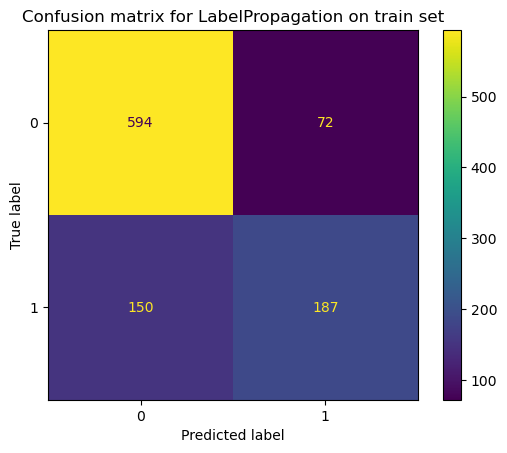

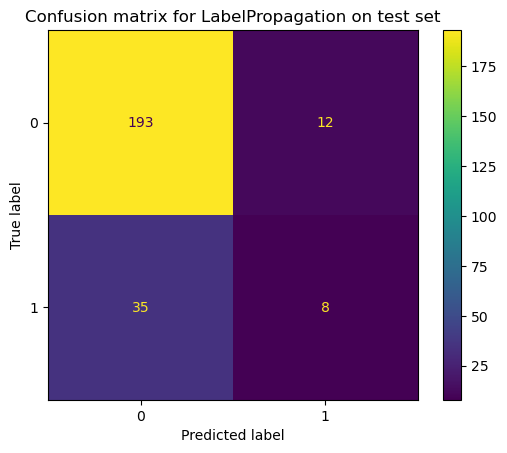

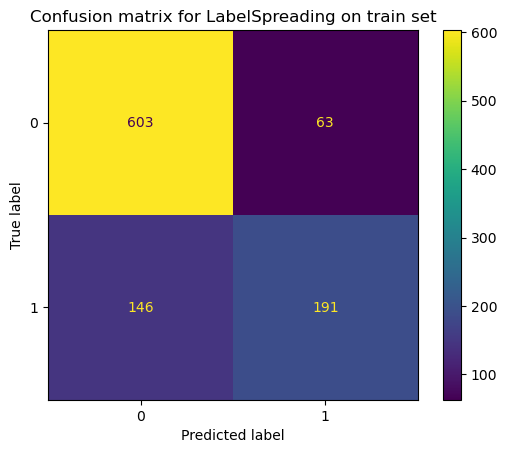

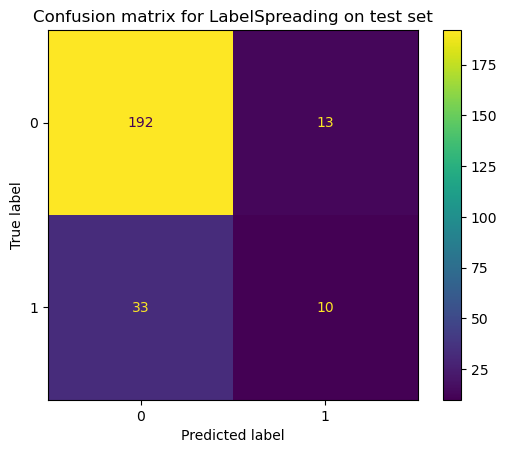

In [16]:
results = []
best_estimators = []

X_train = split_datasets['X_germany_train']
y_train = split_datasets['y_germany_train']

for m in models:
    print('---')
    print(f'Training {m[0]} model')
    pipeline = Pipeline(steps=[('preprocess', preprocessor), ('model', m[1])])

    # Find best hyperparams with RandomizedSearchCV
    rscv = RandomizedSearchCV(pipeline, params[m[0]], cv=5, n_jobs=-1, verbose=1, scoring=ndcg_scorer)
    # rscv = RandomizedSearchCV(pipeline, params[m[0]], cv=5, n_jobs=-1, verbose=1, scoring='accuracy')
    rscv.fit(X_train, y_train)
    
    # Save the model
    # dump(rscv, f'../logs/trained_models/{m[0]}.joblib')

    results.append((m[0], pd.DataFrame(rscv.cv_results_)))
    best_estimators.append((m[0], rscv.best_estimator_))
    print(f"best training hyperparamters: {rscv.best_params_}")


# Print report 
for model_name, estimator in best_estimators:
    print(f'-------- {model_name} Train --------')
    y_pred_train = estimator.predict(X_train)
    NDCG_score_train = ndcg_custom_scorer(y_train, y_pred_train, k=K)
    print(f'{model_name} NDCG@{K} score: {NDCG_score_train}')
    print(f'{model_name} accuracy score: {accuracy_score(y_train, y_pred_train)}')
    print(f'{model_name} recall score: {recall_score(y_train, y_pred_train)}')
    print(f'{model_name} precision score: {precision_score(y_train, y_pred_train)}')
    print(f'{model_name} F1 score: {f1_score(y_train, y_pred_train)}')
    print()
    conf_matrix_train = confusion_matrix(y_train, y_pred_train)
    display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_train, display_labels=estimator.classes_)
    display.plot()
    display.ax_.set_title(f"Confusion matrix for {model_name} on train set")

    print(f'-------- {model_name} Test --------')
    y_pred = estimator.predict(X_test)
    NDCG_score = ndcg_custom_scorer(y_test, y_pred, k=K)
    print(f'{model_name} NDCG@{K} score: {NDCG_score}')
    print(f'{model_name} accuracy score: {accuracy_score(y_test, y_pred)}')
    print(f'{model_name} recall score: {recall_score(y_test, y_pred)}')
    print(f'{model_name} precision score: {precision_score(y_test, y_pred)}')
    print(f'{model_name} F1 score: {f1_score(y_test, y_pred)}')
    print()
    conf_matrix = confusion_matrix(y_test, y_pred)
    display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=estimator.classes_)
    display.plot()
    display.ax_.set_title(f"Confusion matrix for {model_name} on test set")